# PART B: NEURAL NETWORK VS. PERCEPTRON

## Question 2: Neural network's decision boundary

In [1]:
library(ggplot2)

This following part of code is taken from provided codebase to facilitate the process of this assignment

In [2]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
    "[<-.result" <- function(x,...,value) {
    args <- as.list(match.call())
    args <- args[-c(1:2,length(args))]
    length(value) <- length(args)
    for(i in seq(along=args)) {
        a <- args[[i]]
        if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
        }
    x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
    data <- read.csv(file=file.name,head=TRUE,sep=",")
    data <- data[complete.cases(data),] # removes rows with NA values
    D <- ncol(data)
    x = data[,-D]
    y = data[,D]
    if (isTRUE(scaling)) {
        x = scale(x)
        y = scale(y)
    }
    return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
    if (length(Y1)!=length(T1)){
        stop('error.rate: size of true lables and predicted labels mismatch')
    }
    return (sum(T1!=Y1)/length(T1))
}

In [3]:
####################### PERCEPTRON #######################
## prediction
perceptron.predict <- function(Phi, W){
    return(ifelse(Phi%*%W >= 0, +1, -1))
}

## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
    return((W%*%Phi)*T1<0)
}

## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=1000, plotting=FALSE){
    if (length(unique(T1))!=2){
        stop("Perceptron: The input data is not a binary classification problem.")
    }
  
    if (all(sort(unique(T1)) != c(-1, 1))) {
        stop("Perceptron: The labels are not (-1, +1).")
    }
  
    N1 <- nrow(X1)
    Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

    W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
    W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
    error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
    error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
    tau <- 1 # iteration counter 
    terminate <- FALSE # termination status
  
    while(!terminate){
        # resuffling train data and associated labels:
        indx <- sample(1:N1, replace = FALSE)
        Phi <- Phi[indx,]
        T1 <- T1[indx]
    
        for (i in 1:N1){
            if (tau >= tau.max) {break}
            # look for missclassified samples
            if (is.a.miss(Phi[i,], W[tau,], T1[i])){
                tau <- tau +1                                 # update tau counter
                W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
                error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
                eta = eta * 0.99                                 # decrease eta
            } 
        }
        # recalculate termination conditions
        terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    }
    
    if (plotting){
        plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
    }
    
    W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
    
    return(W[nrow(W),])         # return the last wight vector
}

In [4]:
####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z, a=1) { #activation function (sigmoid here)
    return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}

## the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
    return (1-(h(z, a))^2)
}

## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
    a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
    a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
    return (a3)
}

## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
    return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}

## feedforward step
    feedforward <- function(Xi, Ti, W1, b1, W2, b2){
    ### 1st (input) layer 
    a1 <- Xi
    y <- Ti
    ### 2nd (hidden) layer
    z2 <- W1 %*% a1 + b1
    a2 <- h(z2)        
    ### 3rd (output) layer
    z3 <- W2 %*% a2 + b2
    a3 <- h(z3)  
    return(list(a1, a2, a3, y, z2, z3))
}

## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
    ### 3rd (output) layer
    d3 <- -(Ti-a3) * h.d(z3)
    ### 2nd (hidden) layer
    d2 <-  t(W2)%*%d3  * h.d (z2)
    return(list(d2,d3))
}

## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
    # initialization
    if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
    D <- nrow(X1)
    if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
    N <- ncol(X1)

    W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
    b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
    W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
    b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

    for (epoch in 1:epoch.max){   
        ## delta vectors/matrices initialization
        W1.d <- W1 *0
        b1.d <- b1 *0
        W2.d <- W2 *0
        b2.d <- b2 *0

        for (i in 1:N){
            ## Feedforward:
            list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
            ## Backpropagation:
            list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
            ## calculate the delta values
            ### 1st layer
            W1.d <- W1.d + d2 %*% t(a1)
            b1.d <- b1.d + d2
            ### 2nd layer
            W2.d <- W2.d + d3 %*% t(a2)
            b2.d <- b2.d + d3
        }
        ## update weight vectors and matrices
        W1 <- W1 - eta * (W1.d/N + lambda*W1)
        b1 <- b1 - eta * (b1.d/N)
        W2 <- W2 - eta * (W2.d/N + lambda*W2)
        b2 <- b2 - eta * (b2.d/N)
        
        ## record the errors
        if (plotting){
            error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)
            plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
        }
    }
    return(list(W1, W2, b1, b2))
}

### Part I: Load Task2B_train.csv and Task2B_test.csv sets, and plot the training data

In [5]:
# Read the datasets
set.seed(1234)          # set random seed
list[X1,T1] <- read.data('./Task2B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('./Task2B_test.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 

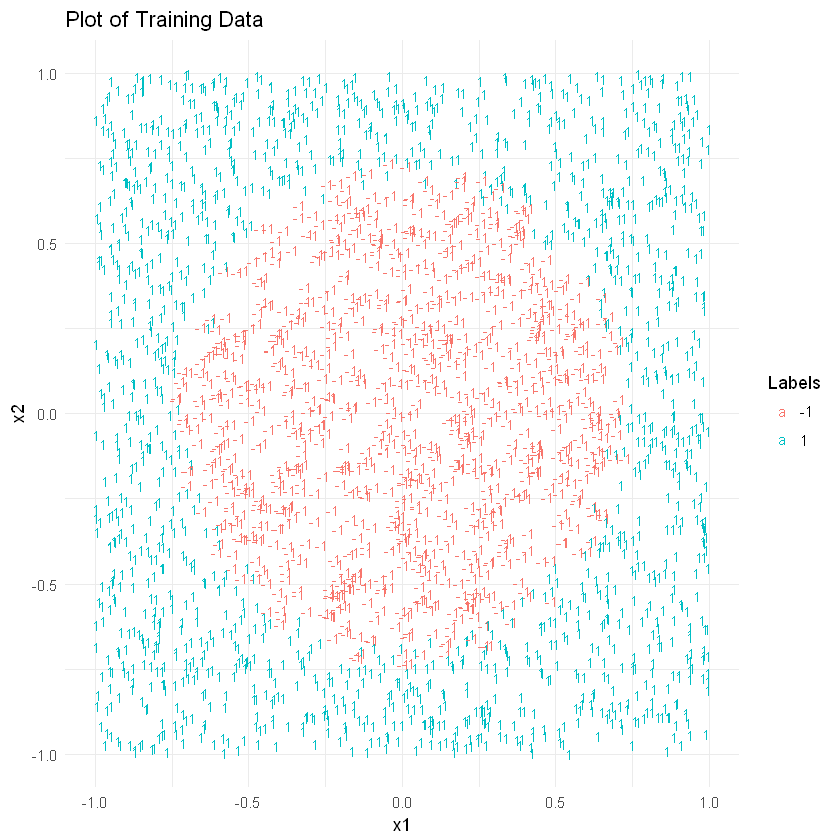

In [6]:
## plot class distribution in the training data set
ggplot(data=as.data.frame(cbind(X1,T1)), aes(x=x1, y=x2, label=T1)) + geom_text(size = 3, aes(colour = factor(T1))) + 
    ggtitle('Plot of Training Data') + theme_minimal() + labs(colour = "Labels")

### Part II: Implement Perceptron classifier, calculate test error and plot the decision boundary of test data

Since the perceptron in sensitive to initial weights, we run the perceptron function several times with different initial weights. We can see that the function returns a different weight for each time. Thus we will plot these weight vectors with training data to see how they perform in this case.

In [7]:
train.data <- as.matrix(cbind(1,X1))
test.data <- as.matrix(cbind(1,X2))

# Build a perceptron with training data
W1 <- perceptron.build(X1, T1, tau.max = 1000, plotting = FALSE) # Run this a few times until you are happy with the result
W2 <- perceptron.build(X1, T1, tau.max = 1000, plotting = FALSE)
W3 <- perceptron.build(X1, T1, tau.max = 1000, plotting = FALSE)

# Predict outcome using the 3 weight vectors above
predict1 <- perceptron.predict(train.data,W1)
predict2 <- perceptron.predict(train.data,W2)
predict3 <- perceptron.predict(train.data,W3)

# Calculate training error of 3 weight vectors
train.err1 <- error.rate(predict1, T1)
train.err2 <- error.rate(predict2, T1)
train.err3 <- error.rate(predict3, T1)

# print the results
cat("\nFirst weight vector:", W1, "\twith training error:", train.err1) 
cat("\nSecond weight vector:", W2, "\twith training error:", train.err2)
cat("\nThird weight vector:", W3, "\twith training error:", train.err3)

#? Plot Perceptron Decision Boundary (TO BE COMPLETE)
## Hint: Plot the testing data with different symbols for each class (real labels). Then color each point based on its predicted label.


First weight vector: 0.009107961 0.08430937 0.06435819 	with training error: 0.512
Second weight vector: -0.06642772 0.05061326 -0.3038988 	with training error: 0.4552
Third weight vector: 0.05584152 -0.1235054 -0.4758694 	with training error: 0.528

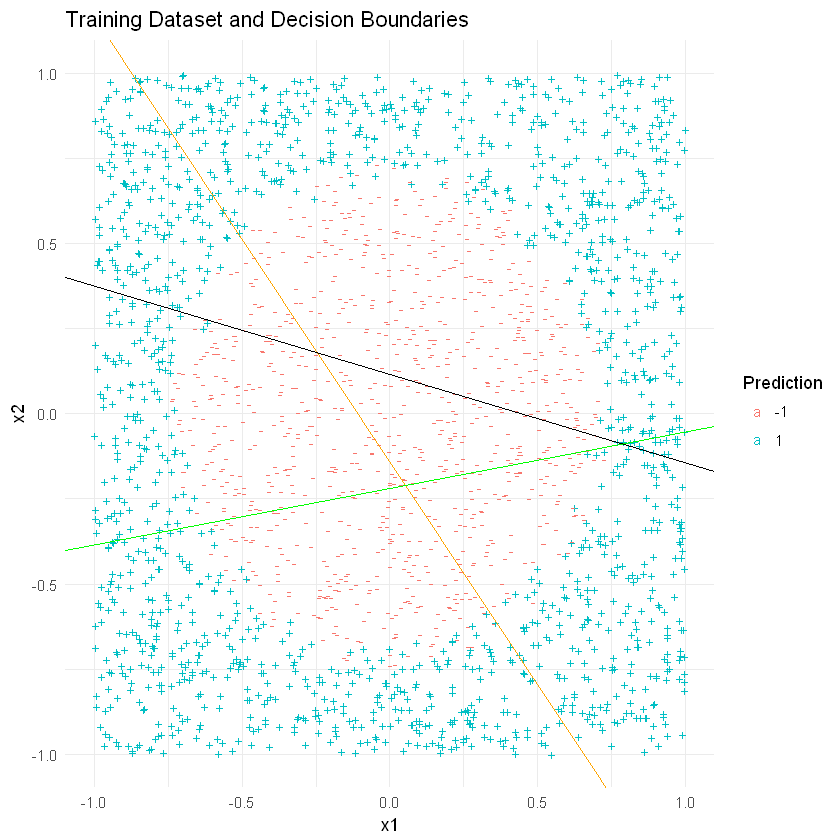

In [8]:
# Visualizations
## Ploting the decision boundary
ggplot(data=as.data.frame(cbind(X1,T1)), aes(x=x1, y=x2, label=ifelse(T1!=-1, '+', '-'))) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    geom_text(size = 3, aes(colour = factor(T1))) + 
    geom_abline(intercept=-W1[1]/W1[3], slope=-W1[2]/W1[3], colour= "orange") +
    geom_abline(intercept=-W2[1]/W2[3], slope=-W2[2]/W2[3], colour= "green") +
    geom_abline(intercept=-W3[1]/W3[3], slope=-W3[2]/W3[3], colour= "black") +
    ggtitle('Training Dataset and Decision Boundaries') + labs(colour = "Labels") +
    theme_minimal()

Because the data is not linearly seperable, it is a bad idea to use Perceptron to train a classifier as we know Perceptron is only used for linear classification.

The plot above shows that Perceptron classifiers does not perform well on training data, as a result we do not expect a high performance on the test data neither.

To calculate the test error, we will use the weight vector 2 which has smallest training error to classify the test data

#### Calculate test error

In [9]:
predict.test <- perceptron.predict(test.data, W2)
test.err <- error.rate(predict.test,T2)
cat("Test error:", test.err)

Test error: 0.4636

#### Plot test data with decision boundary

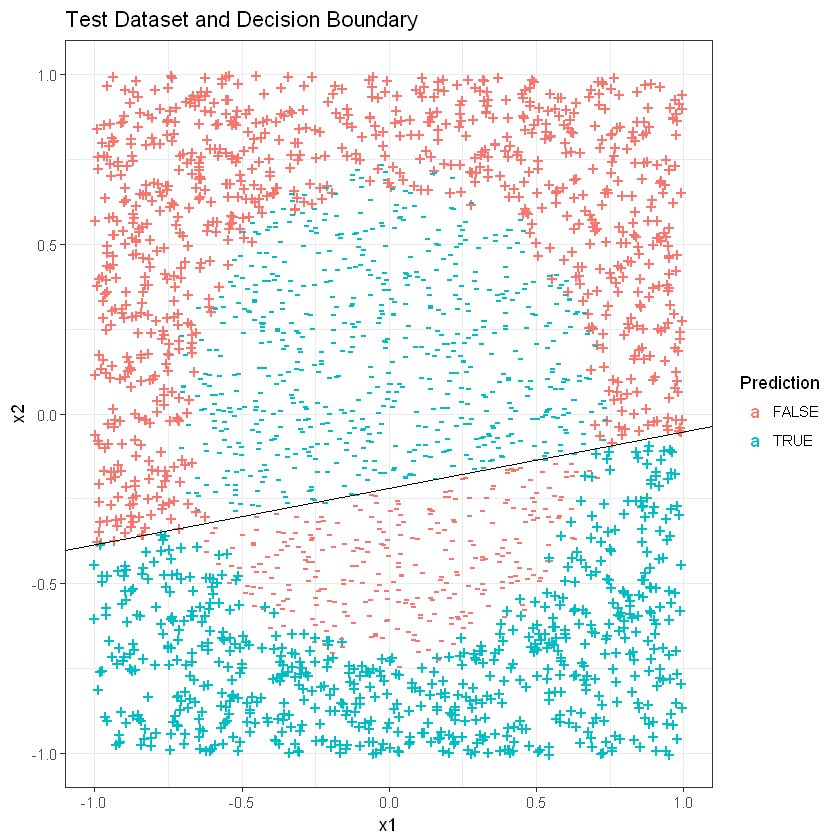

In [10]:
# Visualizations
## Ploting the decision boundary
ggplot(data=as.data.frame(cbind(X2,T2)), aes(x=x1, y=x2, color = factor(predict.test == T2), label=ifelse(T2!=-1, '+', '-'))) +
    geom_text(alpha=1) + scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    geom_abline(intercept= -W2[1]/W2[3], slope= -W2[2]/W2[3]) +
    ggtitle('Test Dataset and Decision Boundary') +
    theme_bw()

From the plot above, we can confirm that the classifer trained by Perceptron does not have a good performance on this kind of dataser. 

### Part III: Implement 3-layer Neural Network

In [11]:
# transpose the dataset
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))

# create a dataframe to record test error corresponding to each value of K
trace.test.err <- data.frame("K"=seq(2,100,2), 'test.err' = rep(0,50))

In [12]:
# run neural netwrok with different values of K and record the test error 
for (k in seq(2, 100, 2)) {
    list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=FALSE, epoch.max=1000, eta = 0.1, lambda = 0.01)
    
    result <- nn.predict(X2.t, W1, W2, b1, b2)
    
    trace.test.err[k/2,'test.err'] <- error.rate(result, T2)
}

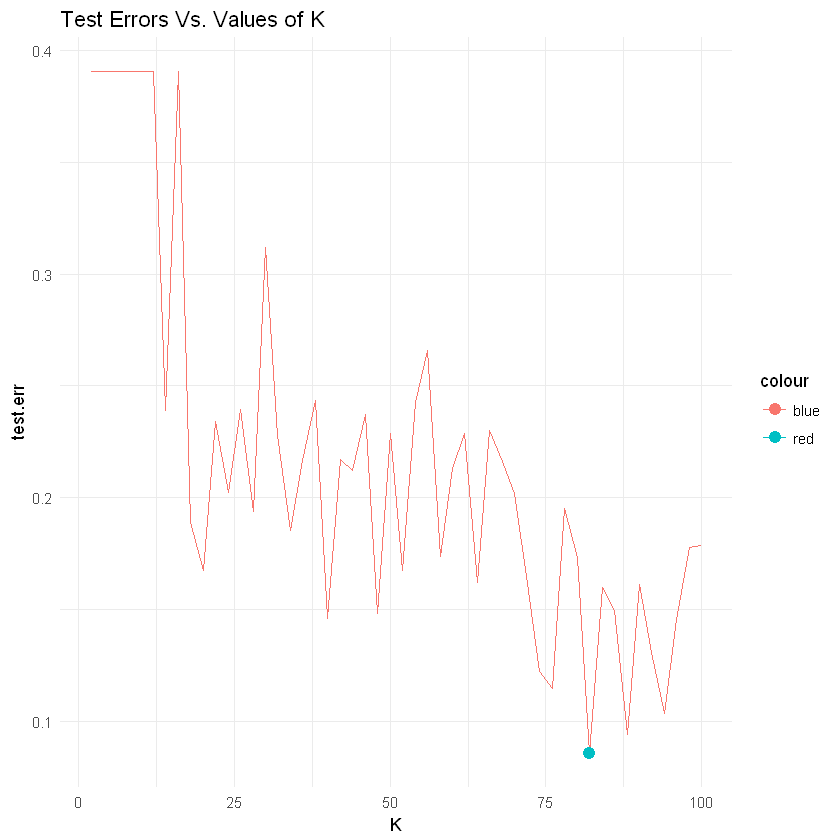

In [13]:
# plot test error corresponding to value of K
ggplot(data=trace.test.err, aes(x=K, y=test.err, color='blue')) + geom_line() + 
        geom_point(aes(x=82, y=min(trace.test.err$test.err), color='red'), size=3) +
        theme_minimal() + ggtitle("Test Errors Vs. Values of K")

#### Plot test data with the model having the best value of K

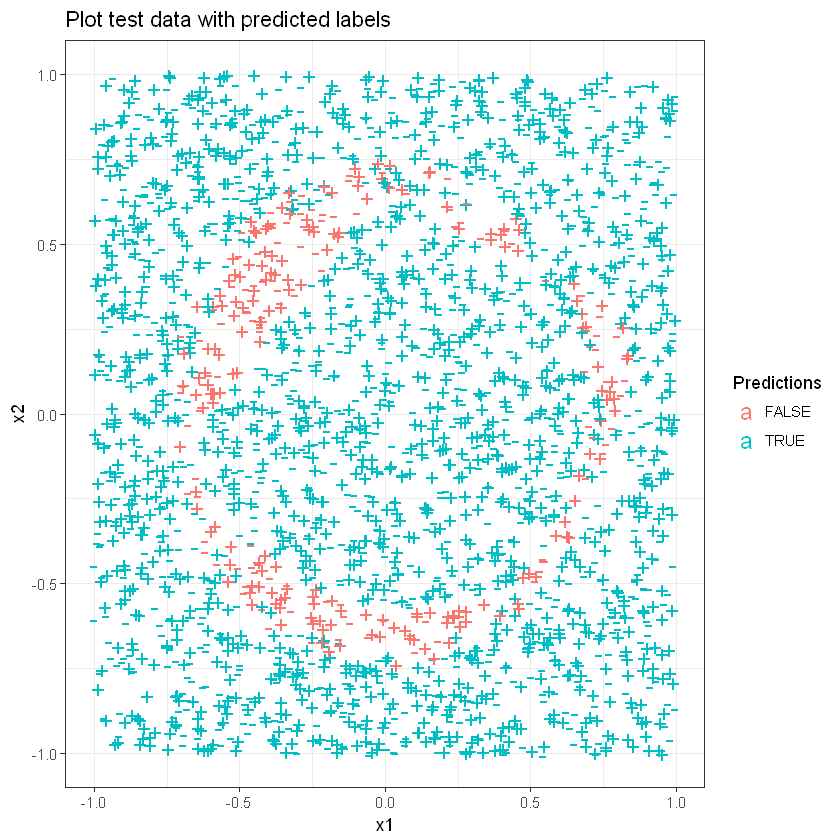

In [14]:
# build the model with the best K
list[best.W1, best.W2, best.b1, best.b2] <- nn.build(82, X1.t, T1, plotting=FALSE, epoch.max=1000, eta = 0.1, lambda = 0.01)

# predict labels of test data
predict_test <- nn.predict(X2.t, best.W1, best.W2, best.b1, best.b2)

# plot test data with predicted labels versus real labels
ggplot(data=as.data.frame(cbind(X2,T2, t(predict_test))), aes(x1, x2, color=factor(predict_test == T2), label=ifelse(T1!=-1, '+', '-'))) +
    geom_text(size = 5) + labs(title = "Plot test data with predicted labels", color = "Predictions")  + theme_bw()

### Part IV: Report the error rates

In [15]:
tbl <- rbind(trace.test.err, c("Perceptron:", test.err))
tbl

K,test.err
2,0.3908
4,0.3908
6,0.3908
8,0.3908
10,0.3908
12,0.3908
14,0.2388
16,0.3908
18,0.1888
20,0.1676


In [16]:
tbl[tbl[,2] == min(tbl$test.err),]
cat("The best model is a 3-layer neural network with K =", min(trace.test.err$test.err))

,K,test.err
41,82,0.0856


The best model is a 3-layer neural network with K = 0.0856

The table above includes test errors obtained by all variants of NN and the perceptron. We can see that a 3-layer neural network with different values of K always yields lower test errors compared to a perceptron. Moreover, a 3-layer neural network with 82 units in the hidden layer (K) will produce the lowest test error of 8.56%, which means it achieves a really high prediction accuracy.

### Part V: Explain the difference between results obtained by Perceptron and a 3-layer Neural Network

The main differences between a Perceptron and Neural Network is that:
- We can refer a Perceptron as a single layer neural network that works as a linear binary classifier, while a neural network which involves many layers can be trained using more advanced algorithms such as feed forward and back propagation. This makes a multi-layer neural network more flexible than a perceptron in performing non-linear classification.
- As mentioned before, a perceptron can perform well in linear classification if the data set is linearly seperable. However, the provided data set cannot be classified using linear classification as we can see from the plots of training and testing data in part I and II. Hence, the a 3-layer NN is more suitable in this case and produces a higher prediction accuracy compared to a perceptron.